In [1]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import scvelo as scv
import loompy
import pandas as pd
import numpy as np
import os
import scanpy as sc
import scipy.stats as stats
from io import StringIO
from sklearn import linear_model
import seaborn as sns
import scanpy.external as sce
%matplotlib inline

In [2]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')
# for beautified visualization
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.serif'] = ['Arial']

## input sample path

First lets find the directory that we are working in

**Note:  SigsDir must be changed depending on the user to allow for proper use of this script**

In [3]:
os.getcwd()

'/mnt/c9b6130c-37e5-4f62-becc-dd4240b42021/CD9'

In [4]:
#set directory to where signature gene lists locates
SigsDir="/mnt/533ee9c3-18c0-4c72-a09e-d9ce5a10ef9e/sig"

## Unique Gene Names

First we want to select the genes that we wish to look at and format them into a data frame that we can use later on

In [5]:
#set the directory for outputs
project_ID="pool_filtered_assign"
scv.settings.figdir=f'{project_ID}_figures'

In [10]:
# load file with velocity information
adata=scv.read(f"{project_ID}_figures/{project_ID}_dy.h5ad")

In [ ]:
# load raw count file
adata=scv.read(f"{project_ID}_raw.h5ad")

In [7]:

#we need to make a directory to store the files in
try:
    directoryName=project_ID+"_figures"
    os.mkdir(directoryName)
except:
    pass

#we need to make a directory to store the files in
#we need to make a directory to store the files in
try:
    directoryName=project_ID+"_DEG"
    os.mkdir(directoryName)
except:
    pass


## Preprocess the Data

now we will take the files from the previous section where we determined spliced/unspliced RNA counts and use them to create RNA velocity trajectory as well as investigate biological alternation in each cell

In [8]:
#calculate the percentage of mitochondrial genes and ribosomal genes
adata.var['MT'] = adata.var_names.str.startswith('MT-')
adata.var['RP'] = adata.var_names.str.startswith('RP')
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata, qc_vars=['RP'], percent_top=None, log1p=False, inplace=True)
#sc.pl.violin(adata, ['n_vars'], groupby='Sample_ID', stripplot=False) 

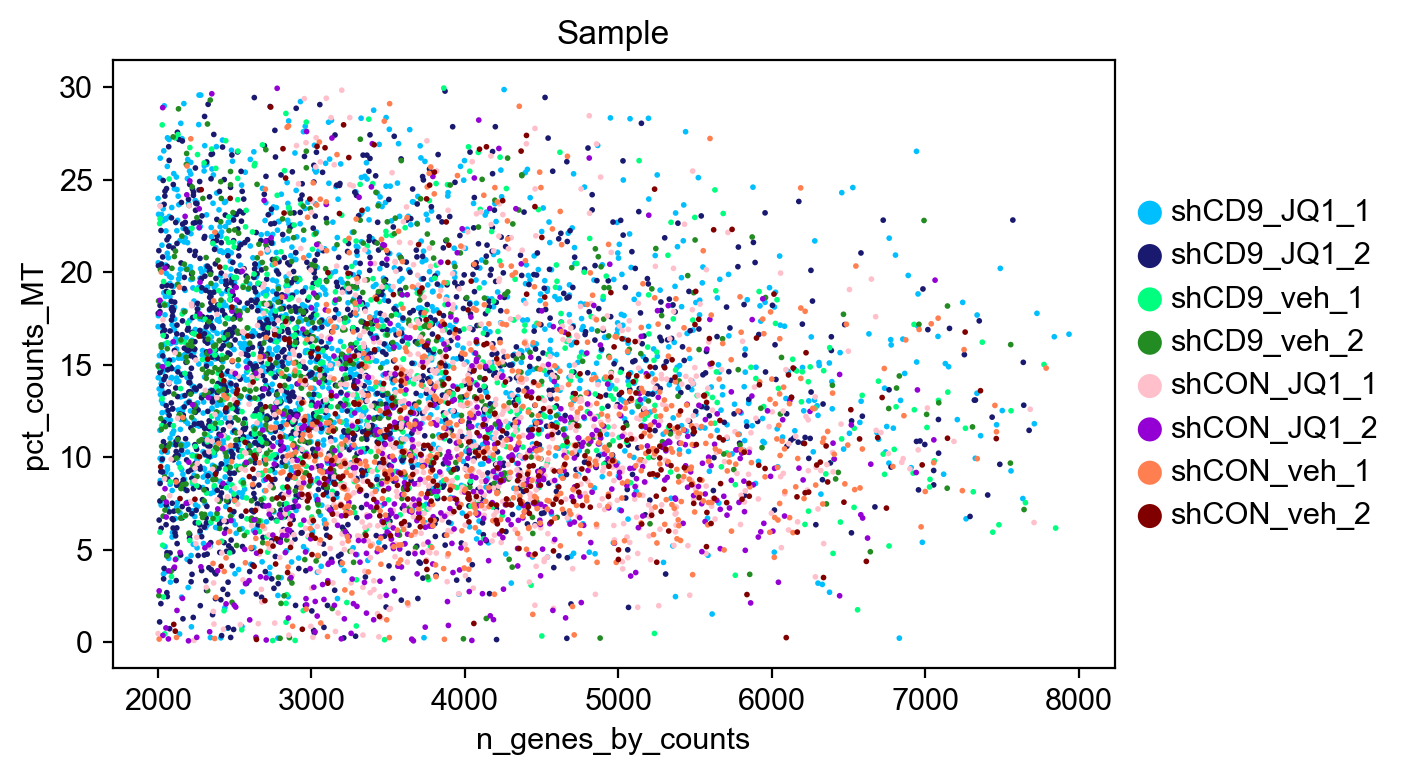

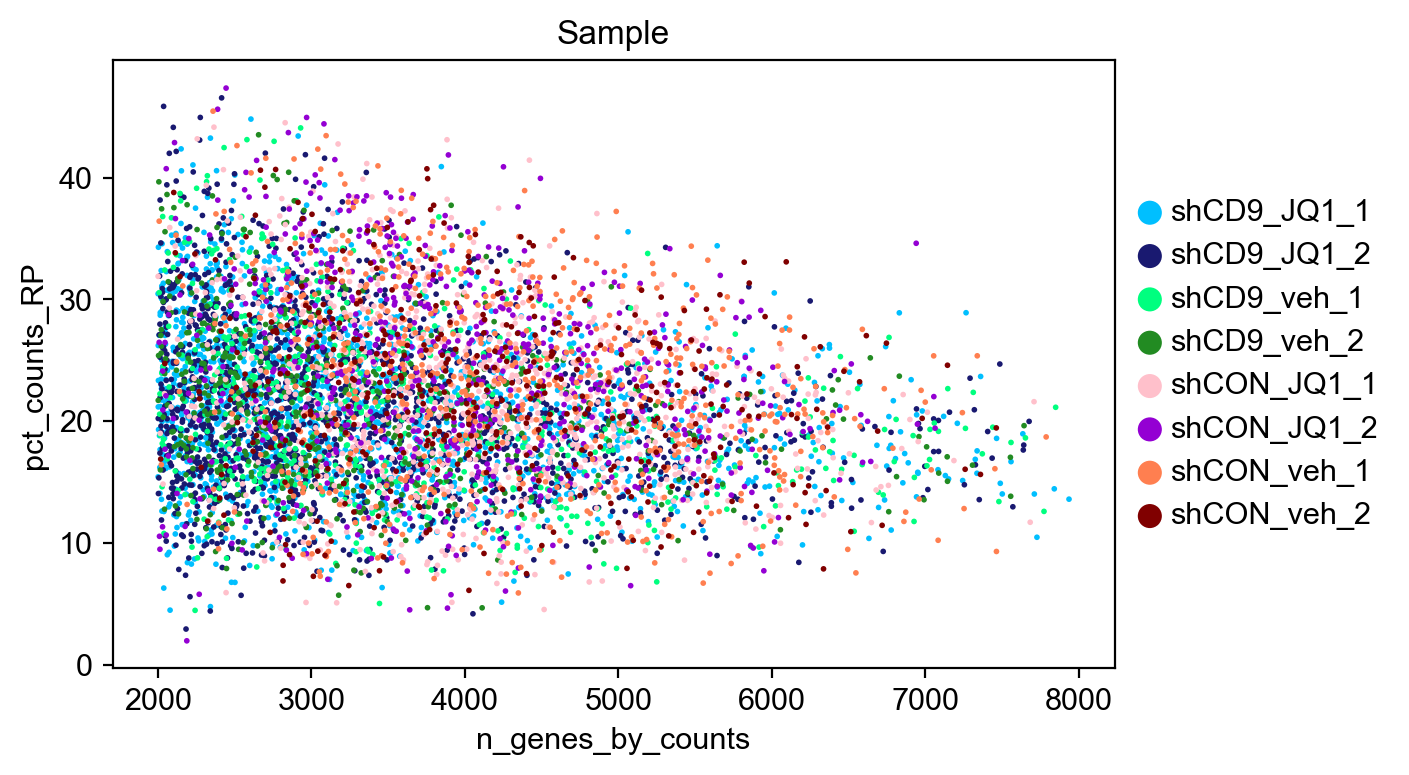

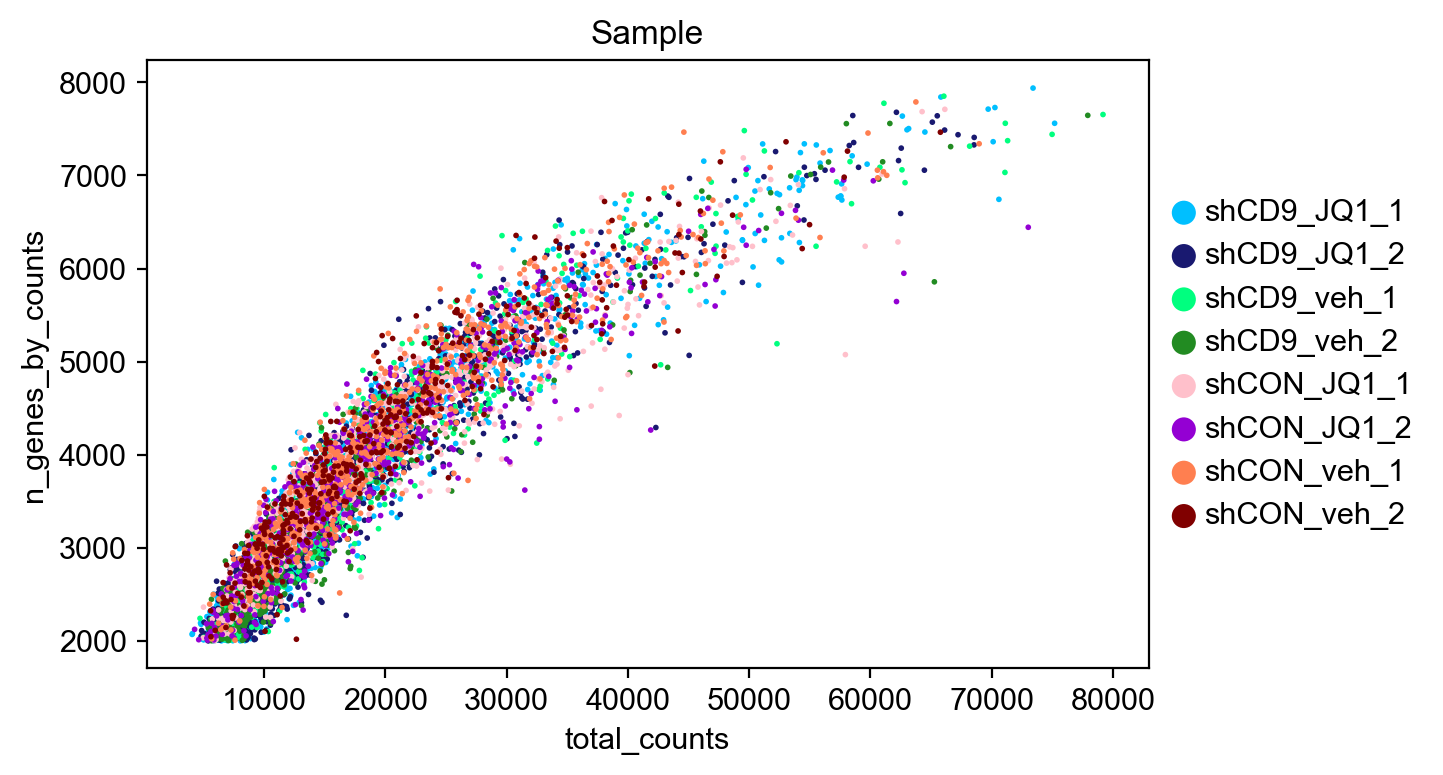

In [11]:
#plot scatter plots of dataset QC
sc.pl.scatter(adata, x='n_genes_by_counts',y='pct_counts_MT', color="Sample",)
sc.pl.scatter(adata, x='n_genes_by_counts', y='pct_counts_RP', color="Sample")
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color="Sample")

when cell membrane is broken, cytoplasmic RNA will be easy to leek out, but mitochondia are still too big to pass the broken membrane, so that high percentage usually suggestes bad cells. But on the contrary, there is paper saying stemness like cell containing high percentage mitochondrial genes to survie stress, so we have to go back to this parameters according to what we will have found later.

**Continued data processing**

In [ ]:
scv.pp.filter_and_normalize(adata, min_counts=0.05*(adata.n_obs), n_top_genes=4000,                        
                        flavor="seurat")

In [ ]:
scv.tl.score_genes_cell_cycle(adata, use_raw=False)
sc.pp.regress_out(adata, keys=["total_counts","n_genes_by_counts","S_score","G2M_score"] , n_jobs=20, copy=False) 
scv.pp.moments(adata,n_pcs=10, n_neighbors=120, mode="distances") # we calculate a moment matrix for further RNA velocity analysis

In [ ]:
raw=pd.DataFrame.sparse.from_spmatrix(adata.raw.X.copy(), index=adata.raw.obs_names, columns=adata.raw.var_names)

In [ ]:
adata_raw= sc.AnnData(raw)
for i in np.unique(adata.obs.columns):
    adata_raw.obs[i]=adata.obs[i]
scv.pp.filter_and_normalize(adata_raw, flavor="seurat")
sc.pp.regress_out(adata_raw, keys=["batch",] , n_jobs=20, copy=False) 

In [ ]:
adata.raw=adata_raw

In [ ]:
#calculate umap
scv.tl.umap(adata, n_components=2, min_dist=0.01, spread=5, maxiter=None, alpha=1,
            gamma=0.1, negative_sample_rate=5, init_pos="spectral", random_state=0, a=None,
            b=None, copy=False, method="umap", neighbors_key=None)

In [ ]:
import densmap

In [ ]:
#This section can create a densmap if disired 
embedding, ro, re = densmap.densMAP(n_neighbors=150, n_epochs=300, dens_frac=0.8,
                                    min_dist=0.1,spread=3,
                                    dens_lambda=0.3).fit_transform(adata.to_df(layer="Ms"))

In [ ]:
adata.obsm["X_densmap"]=embedding

In [ ]:
#calculate louvain clusters based on the umap we generated previously
sc.tl.leiden(adata, resolution=0.2,
                 key_added='leiden', use_weights=True)

In [ ]:
#check proportions of spliced and unspliced RNA in each cluster
scv.pl.proportions(adata, groupby="clusters")

In [ ]:
adata.obs["clusters"]=adata.obs["leiden"]

In [ ]:
#plot umap grouped by treatment
plot_pattern="treatment"
scv.pl.scatter(adata, save=f"{plot_pattern}_densmap.pdf",
               basis="densmap",
           color=plot_pattern,legend_loc="right",
            size=30, alpha=0.6,
            palette=[ 
             "royalblue","gold",
            "firebrick",#"lightcoral",
            #"tan",
                "slategrey","coral","lightseagreen"
            ,"lightsteelblue","lightskyblue","dimgrey",
            "indigo","darkturquoise"], )

In [ ]:
#plot umap grouped by treatment
plot_pattern="phase"
scv.pl.scatter(adata_, save=f"{plot_pattern}_densmap.pdf",
               basis="densmap",
           color=plot_pattern,legend_loc="right",
            size=50, alpha=0.6,
            palette=[ 
             "gold","orchid",
            "firebrick","lightcoral",
            "tan","slategrey","coral","lightseagreen"
            ,"lightsteelblue","lightskyblue","dimgrey",
            "indigo","darkturquoise"], )

In [ ]:
#plot umap grouped by treatment
plot_pattern='clusters'
scv.pl.scatter(adata_, save=f"{plot_pattern}_densmap.pdf",
               basis="umap",
           color=plot_pattern,legend_loc="right",
            size=20, alpha=0.6,          
            palette=[ "DeepSkyBlue","MidnightBlue","Pink","darkviolet",
                    "SpringGreen","forestgreen","maroon"
            , "gold","orchid","crimson"
            ,"firebrick","olivedrab","lightcoral","greenyellow"
            ,"tan","slategrey","coral","lightseagreen"
            ,"lightsteelblue","lightskyblue","dimgrey",
            "indigo","darkturquoise"], )

In [ ]:
#plot umap grouped by treatment
plot_pattern='scPred'
scv.pl.scatter(adata_,# save=f"{plot_pattern}_densmap.pdf",
               basis="umap",
           color=plot_pattern,legend_loc="right",
            size=20, alpha=0.6,          
            palette=[ "DeepSkyBlue","MidnightBlue","Pink","darkviolet",
                    "SpringGreen","forestgreen","maroon"
            , "gold","orchid","crimson"
            ,"firebrick","olivedrab","lightcoral","greenyellow"
            ,"tan","slategrey","coral","lightseagreen"
            ,"lightsteelblue","lightskyblue","dimgrey",
            "indigo","darkturquoise"], )

In [ ]:
#plot umap grouped by treatment
plot_pattern="Sample"
scv.pl.scatter(adata, save=f"{plot_pattern}_umap.pdf",
               basis="densmap",
           color=plot_pattern,legend_loc="right",
            size=20, alpha=0.6,
            palette=[ "DeepSkyBlue","MidnightBlue",
                    "SpringGreen","forestgreen","Pink","darkviolet","coral","maroon"
            , "orchid","crimson"
            ,"firebrick","olivedrab","lightcoral","greenyellow"
            ,"tan","slategrey","lightseagreen"
            ,"lightsteelblue","lightskyblue","dimgrey",
            "indigo","darkturquoise"], )

In [ ]:
#plot umap grouped by treatment
plot_pattern="treatment"
scv.pl.scatter(adata, save=f"{plot_pattern}_umap.pdf",
               basis="densmap",
           color=plot_pattern,legend_loc="right",
            size=20, alpha=0.6,
            palette=[ "MidnightBlue",
                    "forestgreen","darkviolet","maroon"
            , "orchid","crimson"
            ,"firebrick","olivedrab","lightcoral","greenyellow"
            ,"tan","slategrey","lightseagreen"
            ,"lightsteelblue","lightskyblue","dimgrey",
            "indigo","darkturquoise"], )

In [ ]:
#plot umap grouped by treatment
color_list=["MidnightBlue",
                    "forestgreen","darkviolet","maroon" ]
#plot umap grouped by treatment
i=0

for x in np.unique(adata.obs.treatment):
    color=["azure","azure","azure","azure"]
    if x == np.unique(adata.obs.treatment)[i]:
        color[i]=color_list[i]
    i=i+1
    scv.pl.scatter(adata, save=f"{x}_umap.pdf",
               basis="densmap",figsize=(3,2),
           color="treatment",legend_loc="right",
            size=30, alpha=0.6,
            palette=color )

In [ ]:
#plot umap grouped by treatment
plot_pattern="phase"
scv.pl.scatter(adata,# save=f"{plot_pattern}_umap.pdf",
               basis="densmap",
           color=plot_pattern,legend_loc="right",
            size=50, alpha=0.8,
            palette=[ "DeepSkyBlue","royalblue","darkviolet","coral",
                    "forestgreen","maroon"
            ,"PapayaWhip", "gold","orchid","crimson"
            ,"firebrick","olivedrab","lightcoral","greenyellow"
            ,"tan","slategrey","lightseagreen"
            ,"lightsteelblue","lightskyblue","dimgrey",
            "indigo","darkturquoise"], )

# calculate signature scores

In [ ]:
# read in an example gene list
gene_list_name="Hallmark_MYC_targets_V1"# put the gene list file name here, the gene list file should be a csv file
gene_list = pd.read_csv(f"{SigsDir}/{gene_list_name}.csv",header=None, sep=",", usecols=[0],)
# convert dataframe or series to list
gene_list_ = gene_list.squeeze().str.strip().tolist()
#glist=np.append(glist,"CD44") # add some specific gene if you want
#glist=np.append(glist,"SETD2")

#calculate a signature expression score by sc internal function. scv cannot calculate a gene list with coefficient
sc.tl.score_genes(adata, score_name=f"{gene_list_name}_score", gene_list=gene_list_, ctrl_size=50, use_raw=True)

In [ ]:
# read in an example gene list
gene_list_random="random_1000_human"# put the gene list file name here, the gene list file should be a csv file
random_list = pd.read_csv(f"{SigsDir}/{gene_list_random}.csv",header=None, sep=",", usecols=[0],)
# convert dataframe or series to list
random_list_ = random_list.squeeze().str.strip().tolist()
random_list_=[genes for genes in random_list_ if genes in adata.raw.var_names]

In [ ]:
gene_list_name="Embryonic_diapause"
gene_list_coe_=pd.read_csv(f"{SigsDir}/{gene_list_name}.csv",header=0, sep=",",usecols=[0,1],index_col=0)
gene_list_coe_=gene_list_coe_.loc[[genes for genes in gene_list_coe_.index if genes in adata.raw.var_names]]

In [ ]:
X_score=0
for genes in gene_list_coe_.index:
    X_score=X_score+gene_list_coe_.loc[genes].values[0]*raw.loc[:,genes]/len(gene_list_coe_)
for genes in random_list_:
    X_score=X_score-raw.loc[:,genes]/len(random_list_)
adata.obs["Embryonic_diapause_score"]=X_score

In [ ]:
sc.pl.dotplot(adata, ["CD9","MYC","MED30",
                         "PSMA3","PSMA5","PSMD13",
                          "CDK4","BRD2","EP300","Hallmark_MYC_targets_V1_score","Hallmark_MYC_targets_V2_score"],groupby="treatment",
              #   layer="spliced",
              standard_scale="var", #use_raw=False,
             #vmin=2, vmax=3,
              cmap="jet", save="CD9_treatment.pdf")

In [ ]:
scv.tl.velocity_confidence(adata)

In [ ]:
#plot umap grouped by treatment
plot_pattern="velocity_length"
scv.pl.scatter(adata,save=f"{plot_pattern}_dens.pdf",
               basis="densmap",color_map="jet",
           color=plot_pattern,legend_loc="right",
            size=20, alpha=0.8, perc=[25,75], smooth=50)

In [ ]:
# we can also make a gene list here manuallly and then calculate a signature s
asymm=["ACTR3","ACTR2","RGS14","RAB10","ETV5","FGF13","ASPM","GOLGA2","STRA8","ING2","INSC","PAX6","POU5F1",
       "PARD3","SOX5","TEAD3","WNT9B","ZBTB16","DOCK7","ARHGEF2",]
sc.tl.score_genes(adata, score_name="asymmetric_division score", gene_list=asymm, ctrl_size=10,use_raw=True)

In [ ]:
# we can also make a gene list here manuallly and then calculate a signature s
ABC=[genes for genes in adata.var_names if genes.startswith("ABC")]
sc.tl.score_genes(adata, score_name="ABC score", gene_list=ABC, ctrl_size=10, use_raw=True)

In [ ]:
# we can also make a gene list here manuallly and then calculate a signature s
ALDH=[genes for genes in adata.var_names if genes.startswith("ALDH")]
sc.tl.score_genes(adata, score_name="ALDH score", gene_list=ALDH, ctrl_size=10, use_raw=True)

In [ ]:
#overlap signature or gene expression in umap
color_name=["asymmetric_division score","ABC score","ALDH score"]
scv.pl.scatter(adata,basis="umap",use_raw=False,
               color=color_name, #layer="unspliced",
               alpha=0.6,size=20, color_map="jet",
               smooth=10,ncols=4
               ,save=f"QC.pdf")

# DEG

In [ ]:
adata_149=sc.read("/mnt/c9b6130c-37e5-4f62-becc-dd4240b42021/TNBC_JQ1/SUM149_figures/SUM149_dy.h5ad")

In [ ]:
sc.tl.rank_genes_groups(adata, 'scPred', method='wilcoxon',
                        n_genes=4000, use_raw=False, pts=True,layer="Ms"
                        ) #when we set layer="spliced", we can extract the DEGs of each cluster according to only normalized and highly virable spliced RNA matrix. When we don't set the layer, we calculate DEGs according to scaled spliced RNA matrix. When we set use_raw="True", we will get DEGs according to raw spliced matrix even without filtering highly virable genes or outliers.

In [ ]:
#sc.tl.filter_rank_genes_groups(adata, min_fold_change=10000000,key_added='rank_genes_groups_filtered',min_in_group_fraction=0.5)
sc.pl.rank_genes_groups(adata
                        , n_genes=25, sharey=False)

In [ ]:
marker_genes={}
for i in np.unique(adata_149.obs.v_clusters):
    marker_genes[i]=result_df_149[f"{i}_n"].values[:25]
    

In [ ]:
marker_matches = sc.tl.marker_gene_overlap(adata, reference_markers=marker_genes, method="jaccard", top_n_markers=15)
marker_matches#.to_csv(f"{project_ID}_figures/SUM149_overlap_Sample.csv")


In [ ]:
#save top50 DEG into dataframe, when we calculate the DEGs according to scaled matrix, because negative numbers in the matrix, we will not be able to get log fold chages, so that we can only summarize pvals_adj in to the dataframe
result = adata_149.uns['rank_genes_groups']
groups = result['names'].dtype.names
result_df_149=pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names' ,'pvals_adj']}).head(100)

In [ ]:
# when we calculate the DEGs from raw data or normalized spliced RNA matrix, we will be able to get a dataframe containing logfoldchages. 
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
result_df=pd.DataFrame(
    {group + '_' + key[:2]: result[key][group]
    for group in groups for key in ['names',"logfoldchanges", 'pvals_adj']}).head(50)

In [ ]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=10, groupby="clusters", use_raw=False,vmin=0, vmax=1, cmap="viridis")

In [ ]:
#we can also select all the meaningful DEG by setting pval or logfoldchange cut-off manually
#for example, when we have a result_df with logfoldchages, we can get the deg list of cluster0, cluster1 and cluster2 by doing

deg=np.array([])
for i in range(0,4):
    deg=np.append(deg,result_df.loc[result_df.iloc[:,i*3+2]<0.05].iloc[:,i*3].values)
deg=np.unique(deg)
len(deg)

In [ ]:
# save the the DEG dataframe as a csv file
result_df.to_csv(f"./{project_ID}_DEG/clusters_DEG4000.csv")

In [ ]:
def grouped_obs_mean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out

In [ ]:
groupby="treatment"
average_expression=grouped_obs_mean(adata, groupby,#layer="spliced",  # when layer=None, it will return an average expression of scaled spliced RNA matrix, which is layer "X"
                                    gene_symbols=None)

In [ ]:
# export the matrix of average expression of cluster DEGs
average_expression.to_csv(f"./{project_ID}_DEG/{groupby}_avr_X.csv")

# TRAJECTORY

read previous h5d file 

In [ ]:
adata.write(f"{project_ID}_figures/{project_ID}_pp.h5ad")

In [ ]:
adata=scv.read(f"{project_ID}_figures/{project_ID}_pp.h5ad")

In [ ]:
#calculate velocity with stochastic mode first
scv.tl.velocity(adata,  mode='stochastic',use_latent_time=True)
scv.tl.velocity_graph(adata)

In [ ]:
#calculate and plot out pseudotime
scv.tl.terminal_states(adata, self_transitions=False)
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot', basis="umap", perc=(2,98), save="pseudotime.pdf")

In [ ]:
#we have to calculate velocity first before we recover dynamics 
scv.tl.recover_dynamics(adata, var_names="velocity_genes" ,plot_results=False, 
                        fit_connected_states=True, use_raw=False, 
                        fit_scaling=True, n_jobs=20)


In [ ]:
#calculate velocity one more time with dynamical mode
scv.tl.velocity(adata,  mode='dynamical',use_latent_time=True)

scv.tl.velocity_graph(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot', basis="umap", perc=(2,98), save="pseudotime.pdf")

In [ ]:
root=pd.Series("0",index=adata.obs_names)
root[adata.obs.clusters=="1"]="1"
adata.obs["root_cells"]=root
adata.obs["root_cells"]=adata.obs["root_cells"].astype(float)

In [ ]:
#sometimes we have to do latent-time if the inter population ransition is not remarkable, you can refer to their oringinal paper for better understanging of the differences between pseudotime and latent-time
scv.pl.scatter(adata, color='end_points', cmap='gnuplot', perc=(2,98), basis="umap", smooth=50, save="latent_time.pdf")#,basis="tsne"
scv.pl.scatter(adata, color='root_cells', cmap='gnuplot', perc=(2,98), basis="umap", smooth=50, save="latent_time.pdf")#,basis="tsne"

In [ ]:
scv.tl.latent_time(adata, vkey='velocity', min_likelihood=0.8  
                   , min_confidence=0.92,
                   min_corr_diffusion=None, weight_diffusion=False, 
                   root_key="root_cells",
                   end_key="end_points", 
                   t_max=None, copy=False)
scv.pl.scatter(adata, color='latent_time', cmap='gnuplot', perc=(2,98), basis="umap", smooth=50, save="latent_time.pdf")#,basis="tsne"

In [ ]:
# plot umap embedded with grid arrows
scv.tl.terminal_states(adata,self_transitions=False)
scv.pl.velocity_embedding(adata, basis='umap', color="lineage", arrow_length=4, arrow_size=2,
                               scale=10, smooth=None, color_map="rainbow",alpha=0.8,size=20,
                               #add_density=True,
                               #add_assignments=True,
                               save="umap_grid_arrow.pdf"
                              )

In [ ]:
# plot umap embedded with grid arrows
scv.tl.terminal_states(adata,self_transitions=False)
scv.pl.velocity_embedding_grid(adata, basis='umap', color="lineage", arrow_length=5, arrow_size=2,
                               scale=10, min_mass=50, smooth=1, n_neighbors=20,color_map="rainbow",alpha=0.5,size=50,
                               #add_density=True,
                               #add_assignments=True,
                               #save="umap_grid_arrow_aggr.pdf"
                              )

In [ ]:
#summarize the arrows of each cluster into 1 single big arrow
adata.uns['neighbors']['distances'] = adata.obsp['distances']
adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']

scv.tl.paga(adata,use_time_prior="latent_time", root_key="root_cells", end_key="end_points" #when we only do velocity pseudotime trajectory we set the use_time_prior="velociyt_pseudotime", when we do latent time trajectory we have to chage the prior time into latent time
           ,groups="scPred",
            threshold_root_end_prior=0.1,
           #,groups='velocity_clusters
           )
df = scv.get_df(adata, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

In [ ]:
#we can set the color of the big dot into Sample_Cluster so that we will get a pie chart of the percentage of each treatment inside 1 cluster
scv.pl.paga(adata_, basis='densmap', size=20, alpha=0.8,
            min_edge_width=2.5, node_size_scale=3, arrowsize=23
            ,save="transition_dens.svg"
            #,color="velocity_clusters"
            ,color="Sample"
            ,threshold=0.0, minimum_spanning_tree=False,
           )


## Cell fraction bar charts

In [ ]:
adata_=adata

In [ ]:
# we can plot feature percentage in the population we group cells, treatment or clusters
# first we need to call a cell_fraction matrix containing matched feature and group_by information of each single cell
feature="phase"
group_by="Sample"
cell_fraction= pd.DataFrame(adata_.obs[group_by].values,columns=[group_by],index=adata_.obs[feature])

second we need to generate a dataframe containing the cell number of each feature in each group

**we go through this chunk only when we group cells by Sample_Clusters**

In [ ]:
fraction=pd.DataFrame([])
for i in np.unique(adata_.obs[group_by]):
    adata__=adata_[adata_.obs[group_by]==i]
    fraction_=np.array([])
    for x in np.unique(adata_.obs[feature]):
        frac=len(adata__[adata__.obs[feature]==x])
        fraction_=pd.Series(np.append(fraction_, frac))
    fraction=pd.concat([fraction, fraction_], axis=1)
fraction.columns=np.unique(adata_.obs[group_by])
fraction.index=np.unique(adata_.obs[feature])

In [ ]:
fraction=pd.DataFrame([])
for i in np.unique(adata_.obs[group_by]):
    adata__=adata_[adata_.obs[group_by]==i]
    fraction_=np.array([])
    for x in np.unique(adata_.obs[feature]):
        frac=len(adata__[adata__.obs[feature]==x])
        fraction_=pd.Series(np.append(fraction_, frac))
    fraction=pd.concat([fraction, fraction_], axis=1)
fraction.columns=np.unique(adata_.obs[group_by])
fraction.index=np.unique(adata_.obs[feature])

In [ ]:
# we calculate the percentage of each feature in each group
fraction.loc["sum"]=fraction.sum(axis=0)
for i in np.unique(adata_.obs[feature]):
    fraction.loc[f"{i}_pct"]=fraction.loc[i]/fraction.loc["sum"]
fraction

In [ ]:
# we drop the cell number rows and leave the percentage rows
fraction_=fraction.T
for i in np.unique(adata_.obs[feature]):
    fraction_=fraction_.drop([i],axis=1)
fraction_=fraction_.drop(["sum"],axis=1)
fraction_

In [ ]:
fraction_.to_csv(f"{project_ID}_figures/{feature}_fraction_{group_by}.csv")

In [ ]:
df_=fraction_
#plot the cell percentage bar chart
labels =np.unique(adata_.obs[group_by])

width = 0.35      # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
x = np.arange(0, len(labels))
bottom=0
for i in range (0, len(df_.columns)): 
    ax.bar(x,  df_.iloc[:,i], width, yerr=None, label=df_.columns[i][:1], bottom=bottom, color=scv.utils.interpret_colorkey(adata_[adata_.obs[feature]==df_.iloc[:,i].name[:-4]],c=f"{feature}"))
    bottom=bottom+df_.iloc[:,i].values
    

plt.xticks(x, labels,rotation=90)
ax.set_ylabel('cell fraction')
ax.set_title('cell fraction')
legend=ax.legend(df_.columns,bbox_to_anchor=(1.05, 1,3,1), loc='upper left', prop={'size':10},borderpad=2)

fig.show()
fig.savefig(f"{project_ID}_figures/{feature}_fraction_{group_by}.pdf",bbox_extra_artists=(legend,),bbox_inches="tight",dpi=300)

## Export meta

In [ ]:
#export meta data for R packages
meta_sample_clusters=pd.concat([adata.obs.clusters, adata.obs.lineage],axis=1)
for i in range (0,4):
    meta_sample_clusters=meta_sample_clusters.replace(f"{i}",f"cluster{i}") 
meta_sample_clusters["cell.names"]=meta_sample_clusters.index.str.replace(f":",".",regex=True)
meta_sample_clusters["cell.names"]=meta_sample_clusters["cell.names"].str.replace("x-","x.",regex=True)
meta_sample_clusters.set_index("cell.names",inplace=True)
meta_sample_clusters.to_csv(f"{project_ID}_DEG/meta_clusters_sample.csv")

In [ ]:
#export meta data for R packages
meta_sample_clusters=pd.concat([adata_.obs.v_clusters, adata_.obs.treatments],axis=1)

meta_sample_clusters["cell.names"]=meta_sample_clusters.index.str.replace(f":",".",regex=True)
meta_sample_clusters["cell.names"]=meta_sample_clusters["cell.names"].str.replace("x-","x.",regex=True)
meta_sample_clusters.set_index("cell.names",inplace=True)
meta_sample_clusters.to_csv(f"{project_ID}_DEG/metadata_gex2.csv")

In [ ]:
#export the full matrix of spliced RNA for CNV analysis in R
matrix=adata.copy().T.to_df(layer="Ms")
#matrix.index=map(lambda x:x.upper(),matrix.index)
matrix.columns=matrix.columns.str.replace("2:","2.",regex=True)
matrix.columns=matrix.columns.str.replace("1:","1.",regex=True)
matrix.to_csv(f"./{project_ID}_DEG/matrix_ms_filtered.csv",header=True)

In [ ]:
#export the full matrix of spliced RNA for CNV analysis in R
matrix=adata_149.copy().T.to_df(layer="Ms")
#matrix.index=map(lambda x:x.upper(),matrix.index)
matrix.columns=matrix.columns.str.replace("DMSO:","DMSO.",regex=True)
matrix.columns=matrix.columns.str.replace("JQ1:","JQ1.",regex=True)
matrix.to_csv(f"./{project_ID}_DEG/matrix149_ms_filtered.csv",header=True)

In [ ]:
#print cluster color list in order to make R output and python output cluster colors identical
print(adata.uns["clusters_colors"])